In [1]:
#%%bash 
#export SUDO_ASKPASS=/Applications/Utilities/XQuartz.app/Contents/MacOS/X11
#ln -sfhv /Library/Frameworks/R.framework/Versions/3.3 /Library/Frameworks/R.framework/Versions/Current

In [65]:
import sys
import os

#%load_ext rpy2.ipython
#%R require(ggplot2)

In [66]:
from deeplate.MMdata import MMData 
import numpy as np
import matplotlib.pyplot as plt
import re
import scipy.ndimage as nd

from skimage.measure import label, regionprops
from skimage import morphology
from skimage.color import label2rgb
import pandas as pd

In [67]:
import deeplate.platesegmenter as ps

In [68]:
#folder = '/Volumes/MusiqueHD/201710126_lowerbound'
folder = '/scicore/home/nimwegen/urchuegu/projects/prj_noise_across_conditions_main/cell_size/data/20170126/201710126_lowerbound/'
#folder = '/scicore/home/nimwegen/urchuegu/projects/prj_noise_across_conditions_main/cell_size/data/20170330/20170330_highmed_1/'

In [69]:
#weights_folder  = '/Users/guillaume/Desktop/PostdocBasel/PlateSegmenter_Python_Git/DeepPlate/Learn201710126/'
weights_folder  = '/scicore/home/nimwegen/witzg/DeepLearningData/Learn20170126_subset_stack2/'

In [116]:
folder_to_save = '/scicore/home/nimwegen/witzg/DeepPlateAnalysis/Learn20170126_part2/'

In [117]:
MMobj = MMData(folder = folder)
print(MMobj.channels)

['GFP', 'DIA (GFP)']


In [118]:
#based on the above outpout set fluo and bright field channels
fluo_ch = 0
bf_ch = 1

In [185]:
#load deep learning model and weights
plate_model = ps.get_unet(10, 304,304)
plate_model.load_weights(weights_folder+'weights.h5')

In [170]:
#get metadata
z_step = MMobj.get_zstep()
positions, well = MMobj.get_position_names()
well_index = np.ravel([[x for x in range(well.shape[0]) if well[x] in y] for y in positions])
well_str = well[well_index]

In [171]:
mid = (MMobj.num_planes[bf_ch]-1)/2

In [172]:
positions.index("B10-Site_1")

5

In [173]:
postovisit = np.arange(0,len(positions),6)

In [184]:
postovisit

array([  0,   6,  12,  18,  24,  30,  36,  42,  48,  54,  60,  66,  72,
        78,  84,  90,  96, 102, 108, 114, 120, 126, 132, 138, 144, 150,
       156, 162, 168, 174, 180, 186, 192, 198, 204, 210, 216, 222])

In [174]:
totpos = len(postovisit)

In [175]:
#collect segmentation matrices
all_masks = np.empty((MMobj.height,MMobj.width,totpos))
all_weights = np.empty((MMobj.height,MMobj.width,totpos))

1/1 [==============================] - 0s 271ms/step


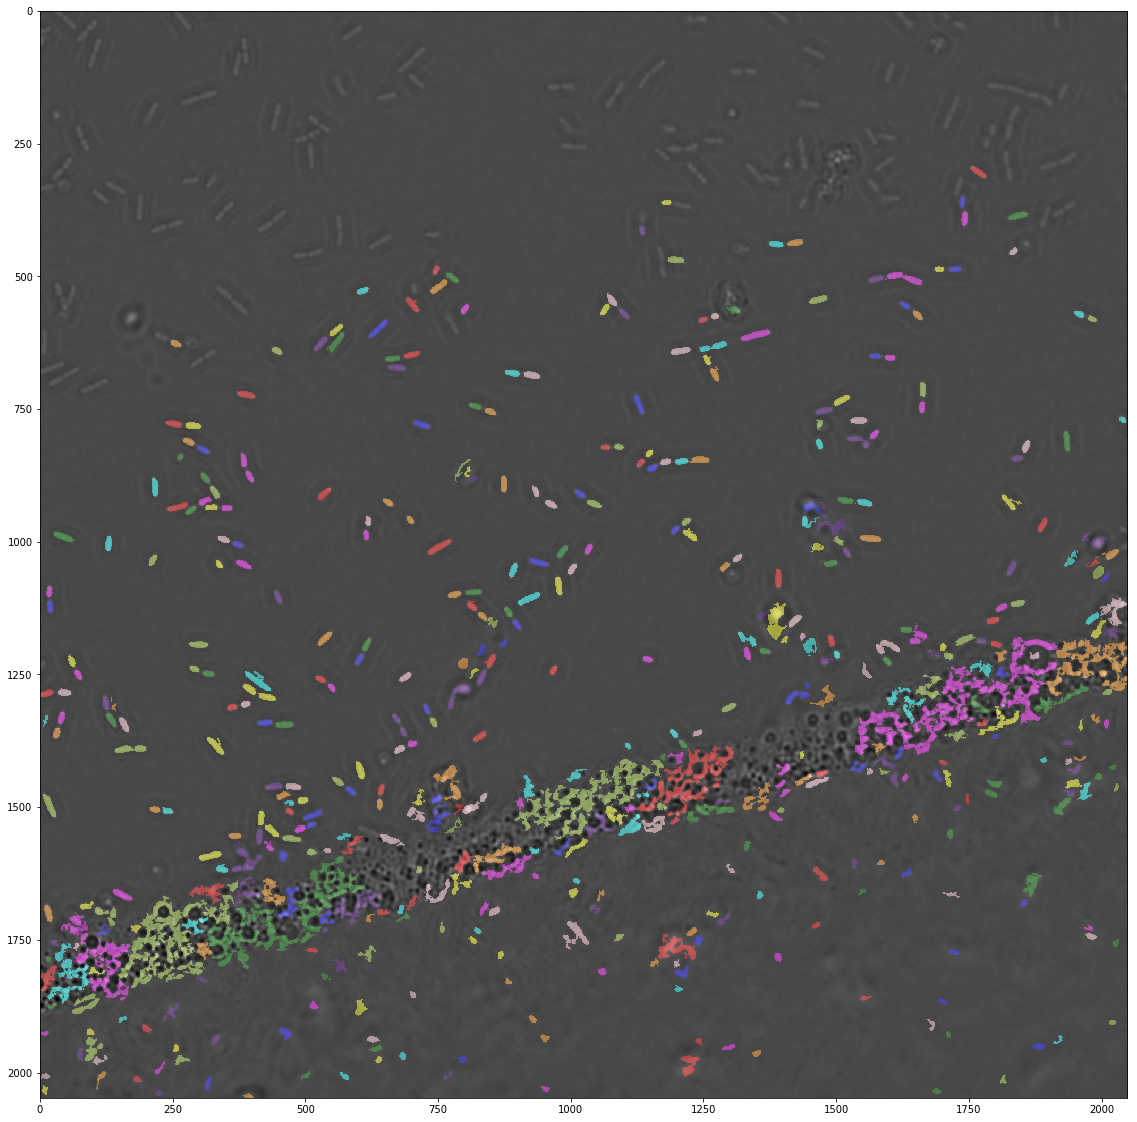

In [187]:
#create folder to save data
if not os.path.exists(folder_to_save):
    os.makedirs(folder_to_save)

#do the segmentation
#for i in range(0,numpoints,3):
for i in range(4,5):
#for i in range(len(postovisit)):
    
    #load bf stack
    #stack = MMobj.get_stack(frame=0,channel=bf_ch,position=i, compress = 1)
    stack = np.empty((MMobj.height,MMobj.width, 10))
    for j in range(10):
        plane = mid-5+j
        stack[:,:,j] = MMobj.get_image(frame=0,channel=bf_ch,plane = plane,position=postovisit[i], compress = 1)
        stack[:,:,j] = nd.gaussian_filter(stack[:,:,j],3)
    meanstack = np.mean(stack,axis =2)
    for m in range(stack.shape[2]):
        stack[:,:,m] = stack[:,:,m]-meanstack
    
    
    stack = stack/np.std(stack)
    
    #load fluo image
    im_fluo = MMobj.get_stack(frame=0,channel=fluo_ch,position=postovisit[i], compress = 1)[:,:,0]
    
    complete = np.empty((MMobj.height,MMobj.width))
    complete_proba = np.empty((MMobj.height,MMobj.width))
    
    topad = 24
    stack = np.pad(stack,((topad,topad),(topad,topad),(0,0)),mode = 'constant')
    for k in range(8):
        for m in range(8):
            
            
            stack_cur = stack[k*256:(k+1)*256+2*topad,m*256:(m+1)*256+2*topad,:]

            plate_im = stack_cur[np.newaxis,...]
            plate_im_mask = plate_model.predict(plate_im, verbose=1)
            plate_im_mask = np.reshape(plate_im_mask,[256+2*topad,256+2*topad])

            #threshold deepe learning segmentation and clean resulting mask
            #plate_im_mask2 = plate_im_mask.copy()
            #plate_im_mask2[plate_im_mask2<0.1]=0
            #plate_im_mask2[plate_im_mask2>0.1]=1

            #complete[k*256:(k+1)*256,m*256:(m+1)*256] = plate_im_mask2
            complete_proba[k*256:(k+1)*256,m*256:(m+1)*256] = plate_im_mask[topad:-topad,topad:-topad]
    
    stack = stack[topad:-topad,topad:-topad,:]
    complete = complete_proba.copy()
    complete[complete<0.9]=0
    complete[complete>0.9]=1
    
    masklab = morphology.label(complete)
    cellinfo = regionprops(masklab, im_fluo)
    overall_mean = np.mean([c.mean_intensity for c in cellinfo])
            
    complete = complete_proba.copy()
    complete[complete<0.1]=0
    complete[complete>0.1]=1
    masklab = morphology.label(complete)
    cellinfo = regionprops(masklab, im_fluo)    
    newMask = np.zeros(masklab.shape)
    for c in cellinfo:
        if (c.label>0)&(c.area>100)&(c.area<10000)&(c.mean_intensity>0.5*overall_mean):#&(c.solidity>0.8)&(c.eccentricity>0.6):
            newMask[masklab==c.label]=1
    all_masks[:,:,i] = newMask
    
    #create a mask for the cell boundary. This mask is used to define the weight-image that helps the 
    #deep learning network to learn those important regions
    distance = nd.distance_transform_edt(newMask)
    distance[distance != 1] = 0
    distance = morphology.binary_dilation(distance)
    distance[newMask==1] = 0
    all_weights[:,:,i] = distance
    
    #save image
    fig, ax = plt.subplots(figsize=(20,20))
    plt.imshow(stack[:,:,0],cmap='gray')
    plt.imshow(label2rgb(label(newMask),bg_label=0),alpha = 0.4)
    plt.show()
    #fig.savefig(folder_to_save+positions[postovisit[i]]+'_id'+str(i)+'_seg.png')
    
#np.save(folder_to_save+'masks.npy', all_masks)

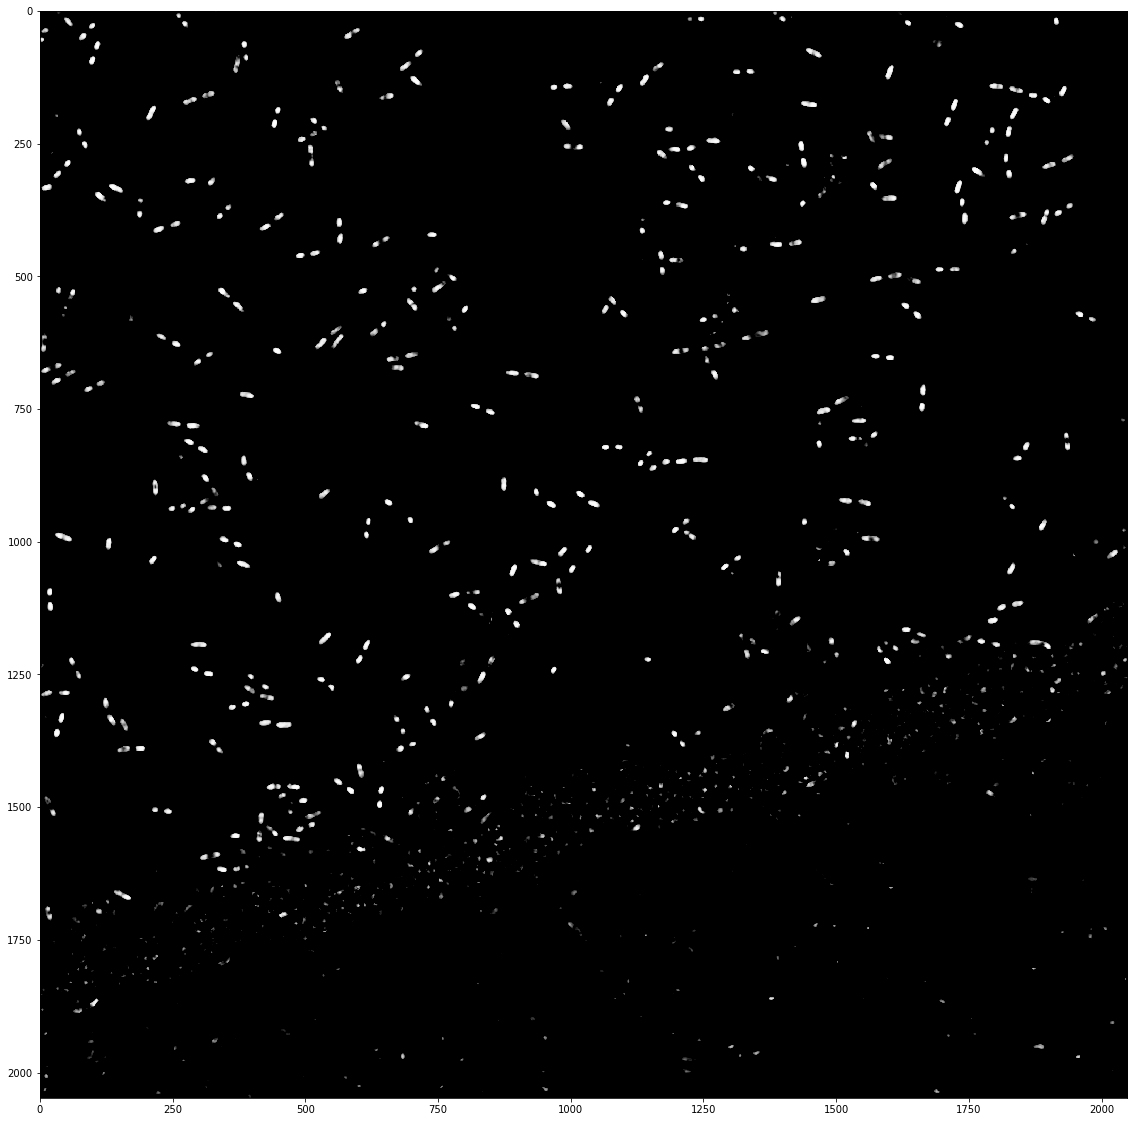

In [189]:
fig, ax = plt.subplots(figsize=(20,20))
plt.imshow(complete_proba,cmap='gray',vmin=0.5)
plt.show()

In [182]:
np.save(folder_to_save+'masks.npy', all_masks)
np.save(folder_to_save+'weights.npy', all_weights)

In [183]:
tokeep = np.array([0,1,2,3,7,23,27])

In [ ]:
all_masks = all_masks[:,:,tokeep]
all_weights = all_weights[:,:,tokeep]

In [ ]:
all_weights[all_weights==11] = 200
all_weights[all_weights==1] = 20
all_weights[all_weights==0] = 1

In [ ]:
multiply = 1
unitsize = 128
numsplits = int(all_masks.shape[0]/unitsize)
numimages = all_masks.shape[2]

#Definition of structures containing training and test datasets
#Dimensions and size of training and test datasets
channels = 10#1
image_rows = unitsize#128
image_cols = unitsize#128
num_test = 20
num_train = multiply*((numsplits**2*numimages)-num_test)


imgs = np.ndarray((num_train, image_rows, image_cols,channels), dtype=np.float64)
imgs_mask = np.ndarray((num_train, image_rows, image_cols), dtype=np.uint8)
imgs_weight = np.ndarray((num_train, image_rows, image_cols), dtype=np.uint8)
imgs_test = np.ndarray((num_test, image_rows, image_cols,channels), dtype=np.float64)
imgs_id = np.ndarray((num_test, ), dtype=np.int32)

In [ ]:
listpos = []
for k in range(numimages):
    for i in range(numsplits):
        for j in range(numsplits):
            listpos.append([i,j,k])
            
shuffle = np.random.choice(len(listpos), len(listpos), replace=False)

